In [1]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
sys.path.append('../input/pytorch-optimizers/')

In [2]:
import os
import gc
import cv2
import copy
import time
import yaml
import random
import shutil
import warnings
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from PIL import Image, ImageDraw
from shutil import copyfile
from IPython.core.display import Video, display
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, GroupKFold, StratifiedKFold

import timm
import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.nn.modules.loss import _WeightedLoss
from torchvision import models, transforms
from torch_optimizer.radam import RAdam

from albumentations.pytorch import ToTensorV2
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout,
    ShiftScaleRotate, CenterCrop, Resize, Rotate, RandomRotate90, RGBShift, ChannelShuffle)

warnings.simplefilter('ignore')
pd.set_option("max_columns", 150)
pd.set_option('display.max_rows', 150)

In [3]:
#timm.list_models(pretrained=True)

# Configuration

In [4]:
CFG = {
    "save_prev"   : [True, ["petfinder_*.pt"]],
    "seed"        : 42,
    'device'      : "cuda:0" if torch.cuda.is_available() else "cpu",
    "input_img"   : '../input/petfinder-pawpularity-score/train/',
    "input_path"  : '../input/petfinder-smogn-dataset/train_drop_duplicated.csv',
    "output_path" : './',
    "db_model"    : 'swin_large_patch4_window7_224_in22k',
    "db_size"     : 224,
    "pretrain"    : None, #"petfinder_swin_binary_%d.pt",
    "save_name"   : "petfinder_swin_binary",
    "model"       : "swin_large_patch4_window7_224_in22k", #tf_efficientnetv2_s_in21k, swin_large_patch4_window12_384_in22k
    "loss"        : "binary",
    "size"        : 224,
    "fold"        : 4,
    "break_fold"  : 99,
    "batch_size"  : 32,
    "epochs"      : 10,
    "mixup_ratio" : 0,
    'T_0'         : 20,
    "lr"          : 2e-5, #0.001,
    'momentum'    : 0.9,
    'weight_decay': 1e-4,
    "accum_iter"  : 2,
    'early_stopping': 10,
    'verbose_step'  : 1,
    "num_workers"   : 4
}

CFG

{'save_prev': [True, ['petfinder_*.pt']],
 'seed': 42,
 'device': 'cuda:0',
 'input_img': '../input/petfinder-pawpularity-score/train/',
 'input_path': '../input/petfinder-smogn-dataset/train_drop_duplicated.csv',
 'output_path': './',
 'db_model': 'swin_large_patch4_window7_224_in22k',
 'db_size': 224,
 'pretrain': None,
 'save_name': 'petfinder_swin_binary',
 'model': 'swin_large_patch4_window7_224_in22k',
 'loss': 'binary',
 'size': 224,
 'fold': 4,
 'break_fold': 99,
 'batch_size': 32,
 'epochs': 10,
 'mixup_ratio': 0,
 'T_0': 20,
 'lr': 2e-05,
 'momentum': 0.9,
 'weight_decay': 0.0001,
 'accum_iter': 2,
 'early_stopping': 10,
 'verbose_step': 1,
 'num_workers': 4}

In [5]:
def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

def sigmoid(a):
    return 1 / (1 + np.exp(-a))

def softmax(x):
    max = np.max(x,axis=1,keepdims=True)
    e_x = np.exp(x - max)
    sum = np.sum(e_x,axis=1,keepdims=True)
    return e_x / sum 

def seed_everything(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG["seed"])

In [6]:
if CFG['save_prev'][0]:
    for file_pattern in CFG['save_prev'][1]:
        for f in glob(f"../input/petfinder-cnn-models/{file_pattern}"):
            !cp {f} ./

# Load data

In [7]:
df_train = pd.read_csv(CFG['input_path'])
df_train["path"] = [f"{CFG['input_img']}{i}.jpg" for i in df_train.Id]
df_train["Pawclass"] = df_train.Pawpularity / 100

meta_features = [c for c in df_train.columns if c not in ["Id","path", "Pawpularity","Pawclass"]]

print(meta_features)
print(df_train.shape)
df_train.head(2)

['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']
(9860, 16)


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path,Pawclass
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,../input/petfinder-pawpularity-score/train/000...,0.63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,../input/petfinder-pawpularity-score/train/000...,0.42


In [8]:
df_train.describe()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,Pawclass
count,9860.000000,9860.000000,9860.000000,9860.000000,9860.000000,9860.000000,9860.000000,9860.000000,9860.000000,9860.000000,9860.000000,9860.000000,9860.000000,9860.000000
mean,0.027586,0.772008,0.903651,0.861460,0.009838,0.067647,0.129209,0.048479,0.165619,0.171197,0.060446,0.070791,38.066227,0.380662
std,0.163792,0.419559,0.295084,0.345483,0.098701,0.251152,0.335448,0.214786,0.371757,0.376700,0.238324,0.256489,20.612391,0.206124
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.010000
25%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,0.250000
50%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000,0.330000
75%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,46.000000,0.460000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000,1.000000


<AxesSubplot:>

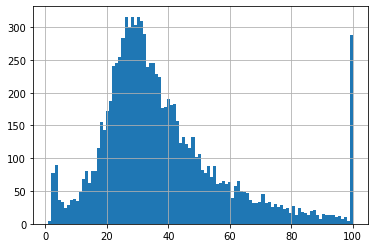

In [9]:
df_train.Pawpularity.hist(bins=100)

# Make dog and cat labels

In [10]:
def load_model(path):
    try:
        checkpoint = torch.load(path, map_location='cpu')
    except Exception as err:
        print(err)
        return None
    model = models.densenet121(pretrained=False)
    model.classifier = nn.Sequential(nn.Linear(1024, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.1),
                                 nn.Linear(256, 2))
    model.parameters = checkpoint['parameters']
    model.load_state_dict(checkpoint['state_dict'])
    return model

In [11]:
def image_transform(imagepath):
    test_transforms = transforms.Compose([transforms.Resize(255),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],
                                                               [0.229, 0.224, 0.225])])
    image = Image.open(imagepath)
    imagetensor = test_transforms(image)
    return imagetensor

class PetFinderDataset(Dataset):
    def __init__(self, df, transforms=None):
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transforms = transforms
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        img = image_transform(self.df.loc[index].path)
        return img

In [12]:
def inference_one_epoch(model, data_loader, device):
    model.eval()

    image_preds_all = []
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for step, (imgs) in pbar:
        imgs = imgs.to(device).float()
        image_preds = model(imgs)
        image_preds_all += [image_preds.detach().cpu().numpy()]
        
    image_preds_all = np.concatenate(image_preds_all, axis=0)
    return image_preds_all

In [13]:
inference_ds = PetFinderDataset(df_train, transforms=None)
data_loader  = torch.utils.data.DataLoader(inference_ds,
                                           batch_size=CFG['batch_size'],
                                           drop_last=False,
                                           pin_memory=False,
                                           shuffle=False,
                                           num_workers=CFG['num_workers'])

model = load_model("../input/cat-vs-dog-model/cat-v-dog-classifier-pytorch-master/models/catvdog.pth")
model.to(CFG["device"])

with torch.no_grad():
    res_cat_dog = inference_one_epoch(model, data_loader, CFG["device"])

del model, inference_ds, data_loader
torch.cuda.empty_cache()

100%|██████████| 309/309 [02:26<00:00,  2.11it/s]


In [14]:
df_train[["cat","dog"]] = softmax(res_cat_dog)
meta_features += ["cat","dog"]

print(df_train.shape)
df_train.head(2)

(9860, 18)


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path,Pawclass,cat,dog
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,../input/petfinder-pawpularity-score/train/000...,0.63,0.001196,0.998804
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,../input/petfinder-pawpularity-score/train/000...,0.42,0.999829,0.000171


# Make dog breed for dog label

In [15]:
class SwinModel(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super().__init__()
        self.model   = timm.create_model(model_name, pretrained=pretrained, num_classes=0, in_chans=3)
        num_features = self.model.num_features
        self.linear  = nn.Linear(num_features, 120)

    def forward(self, x):
        x = self.model(x)
        output = self.linear(x)
        return output

In [16]:
class PetFinderDataset(Dataset):
    def __init__(self, df, size, transforms=None):
        super().__init__()
        self.df   = df.reset_index(drop=True).copy()
        self.size = size
        self.transforms  = transforms
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        img  = get_img(self.df.loc[index].path).copy()
        if self.transforms:
            h, w, _ = img.shape
            trans = self.transforms(self.size, h, w)
            img   = trans(image=img)['image']
        return img
    
def get_inference_transforms(size, h, w):
    h = int(size*1.2) if int(size*1.2) < h else h
    w = int(size*1.2) if int(size*1.2) < w else w
    return Compose([
        CenterCrop(h, w, p=1.0),
        Resize(size, size, p=1.0),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)], p=1.0)

In [17]:
def inference_one_epoch(model, data_loader, device):
    model.eval()

    image_preds_all = []
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for step, (imgs) in pbar:
        imgs = imgs.to(device).float()
        image_preds = model(imgs)
        image_preds_all += [image_preds.detach().cpu().numpy()]
        
    image_preds_all = np.concatenate(image_preds_all, axis=0)
    return image_preds_all

In [18]:
inference_ds = PetFinderDataset(df_train, size=CFG["db_size"], transforms=get_inference_transforms)
data_loader  = torch.utils.data.DataLoader(inference_ds,
                                           batch_size=CFG['batch_size'],
                                           drop_last=False,
                                           pin_memory=False,
                                           shuffle=False,
                                           num_workers=CFG['num_workers'])

model = SwinModel(CFG['db_model'], pretrained=False)
model.load_state_dict(torch.load("../input/petfinder-dogbreed-cnn-models/dogbreed_swin_binary.pt"))
model.to(CFG["device"])

with torch.no_grad():
    res_dogbreed = inference_one_epoch(model, data_loader, CFG["device"])

del model, inference_ds, data_loader
torch.cuda.empty_cache()

100%|██████████| 309/309 [02:41<00:00,  1.91it/s]


In [19]:
df_dogbreed = pd.DataFrame(softmax(res_dogbreed))
df_dogbreed["dog"] = softmax(res_cat_dog)[:,1] > 0.5
df_dogbreed.loc[df_dogbreed.dog==False, :120] = 0
df_dogbreed = df_dogbreed.drop("dog", axis=1)
df_dogbreed.columns = [f"db{i}" for i in df_dogbreed.columns]

print(df_dogbreed.shape)
df_dogbreed.head(2)

(9860, 120)


,db0,db1,db2,db3,db4,db5,db6,db7,db8,db9,db10,db11,db12,db13,db14,db15,db16,db17,db18,db19,db20,db21,db22,db23,db24,db25,db26,db27,db28,db29,db30,db31,db32,db33,db34,db35,db36,db37,db38,db39,db40,db41,db42,db43,db44,db45,db46,db47,db48,db49,db50,db51,db52,db53,db54,db55,db56,db57,db58,db59,db60,db61,db62,db63,db64,db65,db66,db67,db68,db69,db70,db71,db72,db73,db74,db75,db76,db77,db78,db79,db80,db81,db82,db83,db84,db85,db86,db87,db88,db89,db90,db91,db92,db93,db94,db95,db96,db97,db98,db99,db100,db101,db102,db103,db104,db105,db106,db107,db108,db109,db110,db111,db112,db113,db114,db115,db116,db117,db118,db119
0,0.000002,0.000001,0.000021,0.000022,0.000339,0.000019,0.000022,0.000009,0.000017,0.000084,0.000005,0.000007,0.000019,0.000008,0.000101,0.000011,0.000088,0.000052,0.000003,0.000002,0.000002,0.000041,0.000021,0.000027,0.000038,0.000149,0.00003,0.000022,0.006871,0.000348,0.000155,0.00011,0.000022,0.000105,0.000246,0.000039,0.000051,0.001706,0.00004,0.000025,0.000044,0.000017,0.000015,0.00011,0.000532,0.000043,0.000069,0.000051,0.000016,0.03528,0.000006,0.000152,0.000163,0.000016,0.000036,0.000051,0.000016,0.000035,0.000003,0.000009,0.000005,0.000008,0.000011,0.000378,7.255213e-07,0.000018,0.000872,0.947656,0.000081,0.000061,0.000077,0.000082,0.000049,0.000058,0.00001,0.000008,0.000068,0.000004,0.000043,0.000018,0.000028,0.000022,0.000018,0.000064,0.00001,0.000026,0.000032,0.000092,0.000043,0.000136,0.000063,0.000636,0.000024,0.000048,0.000042,0.000041,0.000015,0.000016,0.000007,0.000017,0.000007,0.000054,0.000009,0.000121,0.000118,0.000018,0.000002,0.000011,0.000113,0.000042,0.000196,0.000014,0.000127,0.000029,0.000567,0.000021,0.000042,0.000056,0.000008,0.000011
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [20]:
df_meta = df_train[meta_features].join(df_dogbreed)

print(df_meta.shape)
df_meta.head(2)

(9860, 134)


,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,cat,dog,db0,db1,db2,db3,db4,db5,db6,db7,db8,db9,db10,db11,db12,db13,db14,db15,db16,db17,db18,db19,db20,db21,db22,db23,db24,db25,db26,db27,db28,db29,db30,db31,db32,db33,db34,db35,db36,db37,db38,db39,db40,db41,db42,db43,db44,db45,db46,db47,db48,db49,db50,db51,db52,db53,db54,db55,db56,db57,db58,db59,db60,db61,db62,db63,db64,db65,db66,db67,db68,db69,db70,db71,db72,db73,db74,db75,db76,db77,db78,db79,db80,db81,db82,db83,db84,db85,db86,db87,db88,db89,db90,db91,db92,db93,db94,db95,db96,db97,db98,db99,db100,db101,db102,db103,db104,db105,db106,db107,db108,db109,db110,db111,db112,db113,db114,db115,db116,db117,db118,db119
0,0,1,1,1,0,0,1,0,0,0,0,0,0.001196,0.998804,0.000002,0.000001,0.000021,0.000022,0.000339,0.000019,0.000022,0.000009,0.000017,0.000084,0.000005,0.000007,0.000019,0.000008,0.000101,0.000011,0.000088,0.000052,0.000003,0.000002,0.000002,0.000041,0.000021,0.000027,0.000038,0.000149,0.00003,0.000022,0.006871,0.000348,0.000155,0.00011,0.000022,0.000105,0.000246,0.000039,0.000051,0.001706,0.00004,0.000025,0.000044,0.000017,0.000015,0.00011,0.000532,0.000043,0.000069,0.000051,0.000016,0.03528,0.000006,0.000152,0.000163,0.000016,0.000036,0.000051,0.000016,0.000035,0.000003,0.000009,0.000005,0.000008,0.000011,0.000378,7.255213e-07,0.000018,0.000872,0.947656,0.000081,0.000061,0.000077,0.000082,0.000049,0.000058,0.00001,0.000008,0.000068,0.000004,0.000043,0.000018,0.000028,0.000022,0.000018,0.000064,0.00001,0.000026,0.000032,0.000092,0.000043,0.000136,0.000063,0.000636,0.000024,0.000048,0.000042,0.000041,0.000015,0.000016,0.000007,0.000017,0.000007,0.000054,0.000009,0.000121,0.000118,0.000018,0.000002,0.000011,0.000113,0.000042,0.000196,0.000014,0.000127,0.000029,0.000567,0.000021,0.000042,0.000056,0.000008,0.000011
1,0,1,1,0,0,0,0,0,0,0,0,0,0.999829,0.000171,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Define model

In [21]:
class Model(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, in_chans=3)
        self.n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(self.n_features, 1)

    def forward(self, x):
        output = self.model(x)
        return output
    
class ModelwithMetadataFirst(nn.Module):
    def __init__(self, model_name, size=CFG["size"], pretrained=True):
        super().__init__()
        self.size  = size
        self.model = timm.create_model(model_name, pretrained=pretrained, in_chans=4)
        self.n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(self.n_features, 1)
        self.linear = nn.Linear(14, size*size)

    def forward(self, x1, x2):
        x = self.linear(x2)
        x = torch.reshape(x, (x2.shape[0], 1, self.size, self.size))
        x = torch.cat((x1, x), dim=1)
        output = self.model(x)
        return output
    
# https://rwightman.github.io/pytorch-image-models/feature_extraction/
class ModelwithMetadataLast(nn.Module):
    def __init__(self, model_name, size=CFG["size"], pretrained=True):
        super().__init__()
        self.size  = size
        self.model = timm.create_model(model_name, pretrained=pretrained, in_chans=3)
        self.n_features = self.model.classifier.in_features
        self.model.reset_classifier(0)
        self.linear1 = nn.Linear(14, self.n_features)
        self.linear2 = nn.Linear(self.n_features, 256)
        self.linear3 = nn.Linear(256, 1)
        self.relu    = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x1, x2):
        x1 = self.model(x1)
        x2 = self.linear1(x2)
        x  = torch.add(x1, x2)
        x  = self.relu(self.linear2(x))
        x  = self.dropout(x)
        output = self.linear3(x)
        return output
    
class ModelwithMetadata(nn.Module):
    def __init__(self, model_name, size=CFG["size"], pretrained=True):
        super().__init__()
        self.size  = size
        self.model = timm.create_model(model_name, pretrained=pretrained, in_chans=4)
        self.n_features = self.model.classifier.in_features
        # Exclude the top layer
        self.model.reset_classifier(0)
        self.linear1 = nn.Linear(134, size*size)
        self.linear2 = nn.Linear(134, self.n_features)
        self.linear3 = nn.Linear(self.n_features, 256)
        self.linear4 = nn.Linear(256, 1)
        self.relu    = nn.ReLU()
        self.dropout = nn.Dropout(0.3)


    def forward(self, x1, x2):
        # Metadata first
        x = self.linear1(x2)
        x = torch.reshape(x, (x2.shape[0], 1, self.size, self.size))
        x = torch.cat((x1, x), dim=1)
        x = self.model(x)
        # Metadata Last
        x2 = self.linear2(x2)
        x  = torch.add(x, x2)
        x  = self.relu(self.linear3(x))
        x  = self.dropout(x)
        output = self.linear4(x)
        return output
    
class SwinModelwithMetadata(nn.Module):
    def __init__(self, model_name, size=CFG["size"], pretrained=True):
        super().__init__()
        self.size  = size
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=0, in_chans=4)
        num_features = self.model.num_features
        self.linear1 = nn.Linear(134, size*size)
        self.linear2 = nn.Linear(134, num_features)
        self.linear3 = nn.Linear(num_features, 256)
        self.linear4 = nn.Linear(256, 1)
        self.relu    = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x1, x2):
        # Metadata first
        x  = self.linear1(x2)
        x  = torch.reshape(x, (x2.shape[0], 1, self.size, self.size))
        x  = torch.cat((x1, x), dim=1)
        x  = self.model(x)
        # Metadata Last
        x2 = self.linear2(x2)
        x  = torch.add(x, x2)
        x  = self.relu(self.linear3(x))
        x  = self.dropout(x)
        output = self.linear4(x)
        return output

In [22]:
class PetFinderDataset(Dataset):
    def __init__(self, df_img, df_meta, transforms=None, train=True, output_meta=True, output_label=True):
        super().__init__()
        self.df_img  = df_img.reset_index(drop=True).copy()
        self.df_meta = df_meta.reset_index(drop=True).copy()
        self.transforms   = transforms
        self.train        = train
        self.output_meta  = output_meta
        self.output_label = output_label
        
    def __len__(self):
        return self.df_img.shape[0]
    
    def __getitem__(self, index: int):
        img  = get_img(self.df_img.loc[index].path)
        y    = torch.from_numpy(np.array(self.df_img.loc[index].Pawclass))
        #y    = torch.from_numpy(np.array(self.df_img.loc[index].Pawpularity))
        meta = torch.from_numpy(np.array(self.df_meta.loc[index], dtype=float))
        if self.transforms:
            if self.train:
                img = self.transforms(image=img)['image']
            else:
                h, w, _ = img.shape
                trans = self.transforms(h, w)
                img   = trans(image=img)['image']
        if self.output_label:
            if self.output_meta:
                return img, meta, y
            else:
                return img, y
        if self.output_meta:
            return img, meta
        return img

In [23]:
def get_train_transforms():
    return Compose([
        Resize(CFG['size'], CFG['size'], p=1.0),
        HorizontalFlip(p=0.5),
        HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)], p=1.0)
  
def get_valid_transforms(h, w):
    return Compose([
        Resize(CFG['size'], CFG['size'], p=1.0),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)], p=1.0)

#https://www.kaggle.com/heyytanay/definitive-pytorch-trainer-mixup-kfolds-w-b
def mixup_augmentation(x:torch.Tensor, y:torch.Tensor, alpha:float = 1.0):
    """
    Function which performs Mixup augmentation
    """
    assert alpha > 0, "Alpha must be greater than 0"
    assert x.shape[0] > 1, "Need more than 1 sample to apply mixup"

    lam = np.random.beta(alpha, alpha)
    rand_idx = torch.randperm(x.shape[0])
    mixed_x  = lam * x + (1 - lam) * x[rand_idx, :]
    target_a, target_b = y, y[rand_idx]
    return mixed_x, target_a, target_b, lam

def prepare_dataloader(train, train_meta, valid, valid_meta):
    train_ds = PetFinderDataset(train, train_meta, transforms=get_train_transforms())
    valid_ds = PetFinderDataset(valid, valid_meta, transforms=get_valid_transforms, train=False)
    train_loader = torch.utils.data.DataLoader(train_ds,
                                               batch_size=CFG['batch_size'],
                                               drop_last=False,
                                               pin_memory=False,
                                               shuffle=True,
                                               num_workers=CFG['num_workers'])
    val_loader = torch.utils.data.DataLoader(valid_ds,
                                             batch_size=CFG['batch_size'],
                                             pin_memory=False,
                                             shuffle=False,
                                             num_workers=CFG['num_workers'])
    return train_loader, val_loader

In [24]:
def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader, device, scheduler=None, schd_batch_update=False):
    model.train()

    t = time.time()
    running_loss = None
    mean_loss    = 0

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (imgs, metas, targets) in pbar:
        imgs    = imgs.to(device).float()
        metas   = metas.to(device).float()
        targets = targets.reshape(-1,1).to(device).float()

        if torch.rand(1)[0] < CFG["mixup_ratio"]:
            mix_img, tar_a, tar_b, lam = mixup_augmentation(imgs, targets, alpha=0.5)
            with autocast():
                img_preds = model(mix_img, metas)
                # Mixup loss calculation
                loss_a = loss_fn(img_preds, tar_a)
                loss_b = loss_fn(img_preds, tar_b)
                loss = (loss_a * lam + (1 - lam) * loss_b) / CFG['accum_iter']
        else:
            with autocast():
                img_preds = model(imgs, metas)
                loss = loss_fn(img_preds, targets) / CFG['accum_iter']
        scaler.scale(loss).backward()

        if running_loss is None:
            running_loss = loss.item()
        else:
            running_loss = running_loss * .99 + loss.item() * .01
        mean_loss += loss.item()

        if ((step + 1) %  CFG['accum_iter'] == 0) or ((step + 1) == len(train_loader)):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad() 
            if scheduler is not None and schd_batch_update:
                scheduler.step()

        if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(train_loader)):
            description = f'epoch {epoch} loss: {running_loss:.4f}'
            pbar.set_description(description)
                
    if scheduler is not None and not schd_batch_update:
        scheduler.step()
    return mean_loss/len(train_loader)
        
def valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False):
    model.eval()

    t = time.time()
    loss_sum   = 0
    sample_num = 0
    img_preds_all = []
    img_truth_all = []
    
    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    for step, (imgs, metas, targets) in pbar:
        imgs    = imgs.to(device)
        metas   = metas.to(device).float()
        targets = targets.reshape(-1,1).to(device).float()
        
        img_preds = model(imgs, metas)
        img_preds_all += [img_preds.detach().cpu().numpy()]
        img_truth_all += [targets.detach().cpu().numpy()]
        
        loss = loss_fn(img_preds, targets)
        loss_sum   += loss.item()*targets.shape[0]
        sample_num += targets.shape[0]  

        if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(val_loader)):
            description = f'epoch {epoch} loss: {loss_sum/sample_num:.4f}'
            pbar.set_description(description)
            
    img_preds_all = (sigmoid(np.concatenate(img_preds_all))*100).astype(int)
    img_truth_all = (np.concatenate(img_truth_all)*100).astype(int)
    #img_preds_all = np.concatenate(img_preds_all)
    #img_truth_all = np.concatenate(img_truth_all)
    rmse = np.sqrt(mean_squared_error(img_preds_all, img_truth_all))
    print('validation rmse = {:.6f}'.format(rmse))
    
    if scheduler is not None:
        if schd_loss_update:
            scheduler.step(loss_sum/sample_num)
        else:
            scheduler.step()
    return rmse, loss_sum/sample_num,  [img_preds_all, img_truth_all]

In [25]:
def sgd_optimizer(model, lr, momentum, weight_decay):
    params = []
    for key, value in model.named_parameters():
        if not value.requires_grad:
            continue
        apply_weight_decay = weight_decay
        apply_lr = lr
        if 'bias' in key or 'bn' in key:
            apply_weight_decay = 0
        if 'bias' in key:
            apply_lr = 2 * lr       # Just a Caffe-style common practice. Made no difference.
        params += [{'params': [value], 'lr': apply_lr, 'weight_decay': apply_weight_decay}]
    optimizer = torch.optim.SGD(params, lr, momentum=momentum)
    return optimizer

class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))

# Run training

In [26]:
folds = StratifiedKFold(
    n_splits=CFG['fold'],
    shuffle=True,
    random_state=CFG['seed']
).split(np.arange(df_train.shape[0]), df_train.Pawpularity.values)
    
all_histories = {}
for fold, (trn_idx, val_idx) in enumerate(folds):
    print('Training with fold {} started'.format(fold))
    print(len(trn_idx), len(val_idx))
    
    train      = df_train.iloc[trn_idx].reset_index(drop=True)
    valid      = df_train.iloc[val_idx].reset_index(drop=True)
    train_meta = df_meta.iloc[trn_idx].reset_index(drop=True)
    valid_meta = df_meta.iloc[val_idx].reset_index(drop=True)
    train_loader, val_loader = prepare_dataloader(train, train_meta, valid, valid_meta)

    not_improved_cnt = 0
    best_rmse  = 999
    best_epoch = 0
    histories  = {}
    device     = torch.device(CFG['device'])
    
    if -1 < CFG["model"].find("swin"):
        model = SwinModelwithMetadata(CFG["model"], size=CFG['size'], pretrained=True)
    else:
        model = ModelwithMetadata(CFG["model"], size=CFG['size'], pretrained=True)
    if CFG['pretrain'] is not None:
        model.load_state_dict(torch.load("../input/petfinder-cnn-models/" + CFG['pretrain'] % fold))
    model.to(device)
    scaler    = GradScaler()
    #optimizer = sgd_optimizer(model, CFG['lr'], CFG['momentum'], CFG['weight_decay'])
    #scheduler = CosineAnnealingLR(optimizer=optimizer, T_max=CFG['T_0'])
    optimizer = RAdam(model.parameters(), lr=CFG['lr'], weight_decay=CFG['weight_decay'])
    scheduler = None
    if CFG["loss"] == "binary":
        loss  = nn.BCEWithLogitsLoss().to(device)
    else:
        loss  = RMSELoss().to(device)

    for epoch in range(CFG['epochs']):
        train_loss = train_one_epoch(epoch, model, loss, optimizer, train_loader, device, scheduler=scheduler, schd_batch_update=False)

        with torch.no_grad():
            rmse, valid_loss, hist = valid_one_epoch(epoch, model, loss, val_loader, device, scheduler=None, schd_loss_update=False)
        histories[epoch] = [train_loss, valid_loss, rmse, hist]

        if rmse < best_rmse:
            print('Best model will be saved to output path after completing this fold')
            best_model = copy.deepcopy(model)
            best_rmse  = rmse
            best_epoch = epoch
            not_improved_cnt = 0
        elif CFG['early_stopping'] == not_improved_cnt:
            print("Met early stopping.")
            break
        else:
            not_improved_cnt += 1

    torch.save(best_model.state_dict(), f"{CFG['output_path']}{CFG['save_name']}_{fold}.pt")
    all_histories[fold] = [best_epoch, histories]
    
    del model, optimizer, train_loader, val_loader, scaler
    torch.cuda.empty_cache()
    
    if CFG["break_fold"] == fold+1:
        break

Training with fold 0 started
7395 2465


Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_large_patch4_window7_224_22k.pth" to /root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22k.pth
epoch 0 loss: 0.6599: 100%|██████████| 78/78 [00:42<00:00,  1.83it/s]


validation rmse = 20.122808
Best model will be saved to output path after completing this fold


epoch 1 loss: 0.6500: 100%|██████████| 78/78 [00:43<00:00,  1.79it/s]


validation rmse = 18.894154
Best model will be saved to output path after completing this fold


epoch 2 loss: 0.6434: 100%|██████████| 78/78 [00:43<00:00,  1.81it/s]


validation rmse = 18.022073
Best model will be saved to output path after completing this fold


epoch 3 loss: 0.6417: 100%|██████████| 78/78 [00:44<00:00,  1.76it/s]


validation rmse = 17.798557
Best model will be saved to output path after completing this fold


epoch 4 loss: 0.6427: 100%|██████████| 78/78 [00:42<00:00,  1.83it/s]

validation rmse = 17.954811



epoch 5 loss: 0.6431: 100%|██████████| 78/78 [00:43<00:00,  1.81it/s]

validation rmse = 17.960775



epoch 6 loss: 0.6451: 100%|██████████| 78/78 [00:43<00:00,  1.80it/s]

validation rmse = 18.133615



epoch 7 loss: 0.6474: 100%|██████████| 78/78 [00:43<00:00,  1.78it/s]

validation rmse = 18.461516



epoch 8 loss: 0.6519: 100%|██████████| 78/78 [00:45<00:00,  1.72it/s]

validation rmse = 18.886476



epoch 9 loss: 0.6511: 100%|██████████| 78/78 [00:44<00:00,  1.76it/s]


validation rmse = 18.806283
Training with fold 1 started
7395 2465


epoch 0 loss: 0.6607: 100%|██████████| 78/78 [00:42<00:00,  1.82it/s]


validation rmse = 20.197996
Best model will be saved to output path after completing this fold


epoch 1 loss: 0.6505: 100%|██████████| 78/78 [00:43<00:00,  1.81it/s]


validation rmse = 18.975034
Best model will be saved to output path after completing this fold


epoch 2 loss: 0.6439: 100%|██████████| 78/78 [00:43<00:00,  1.78it/s]


validation rmse = 18.143568
Best model will be saved to output path after completing this fold


epoch 3 loss: 0.6418: 100%|██████████| 78/78 [00:42<00:00,  1.82it/s]


validation rmse = 17.882091
Best model will be saved to output path after completing this fold


epoch 4 loss: 0.6431: 100%|██████████| 78/78 [00:43<00:00,  1.79it/s]


validation rmse = 18.042389


epoch 5 loss: 0.6428: 100%|██████████| 78/78 [00:43<00:00,  1.80it/s]

validation rmse = 17.976478



epoch 6 loss: 0.6460: 100%|██████████| 78/78 [00:42<00:00,  1.83it/s]


validation rmse = 18.329251


epoch 7 loss: 0.6460: 100%|██████████| 78/78 [00:44<00:00,  1.73it/s]

validation rmse = 18.316410



epoch 8 loss: 0.6482: 100%|██████████| 78/78 [00:44<00:00,  1.76it/s]


validation rmse = 18.566923


epoch 9 loss: 0.6490: 100%|██████████| 78/78 [00:42<00:00,  1.82it/s]


validation rmse = 18.676351
Training with fold 2 started
7395 2465


epoch 0 loss: 0.6592: 100%|██████████| 78/78 [00:43<00:00,  1.81it/s]


validation rmse = 20.003489
Best model will be saved to output path after completing this fold


epoch 1 loss: 0.6488: 100%|██████████| 78/78 [00:42<00:00,  1.83it/s]


validation rmse = 18.752244
Best model will be saved to output path after completing this fold


epoch 2 loss: 0.6447: 100%|██████████| 78/78 [00:42<00:00,  1.83it/s]


validation rmse = 18.205955
Best model will be saved to output path after completing this fold


epoch 3 loss: 0.6415: 100%|██████████| 78/78 [00:46<00:00,  1.68it/s]


validation rmse = 17.761035
Best model will be saved to output path after completing this fold


epoch 4 loss: 0.6410: 100%|██████████| 78/78 [00:43<00:00,  1.80it/s]


validation rmse = 17.711183
Best model will be saved to output path after completing this fold


epoch 5 loss: 0.6428: 100%|██████████| 78/78 [00:41<00:00,  1.86it/s]

validation rmse = 17.931909



epoch 6 loss: 0.6492: 100%|██████████| 78/78 [00:42<00:00,  1.86it/s]

validation rmse = 18.703364



epoch 7 loss: 0.6463: 100%|██████████| 78/78 [00:41<00:00,  1.87it/s]

validation rmse = 18.294359



epoch 8 loss: 0.6500: 100%|██████████| 78/78 [00:45<00:00,  1.71it/s]


validation rmse = 18.778381


epoch 9 loss: 0.6514: 100%|██████████| 78/78 [00:41<00:00,  1.88it/s]


validation rmse = 18.883877
Training with fold 3 started
7395 2465


epoch 0 loss: 0.6568: 100%|██████████| 78/78 [00:42<00:00,  1.84it/s]


validation rmse = 19.700866
Best model will be saved to output path after completing this fold


epoch 1 loss: 0.6478: 100%|██████████| 78/78 [00:42<00:00,  1.85it/s]


validation rmse = 18.572963
Best model will be saved to output path after completing this fold


epoch 2 loss: 0.6430: 100%|██████████| 78/78 [00:45<00:00,  1.70it/s]


validation rmse = 17.963982
Best model will be saved to output path after completing this fold


epoch 3 loss: 0.6429: 100%|██████████| 78/78 [00:42<00:00,  1.86it/s]

validation rmse = 17.968340



epoch 4 loss: 0.6433: 100%|██████████| 78/78 [00:41<00:00,  1.86it/s]

validation rmse = 17.973149



epoch 5 loss: 0.6460: 100%|██████████| 78/78 [00:45<00:00,  1.70it/s]

validation rmse = 18.275578



epoch 6 loss: 0.6442: 100%|██████████| 78/78 [00:42<00:00,  1.82it/s]

validation rmse = 18.078228



epoch 7 loss: 0.6468: 100%|██████████| 78/78 [00:41<00:00,  1.87it/s]


validation rmse = 18.378244


epoch 8 loss: 0.6502: 100%|██████████| 78/78 [00:43<00:00,  1.78it/s]

validation rmse = 18.679381



epoch 9 loss: 0.6557: 100%|██████████| 78/78 [00:42<00:00,  1.82it/s]


validation rmse = 19.299981


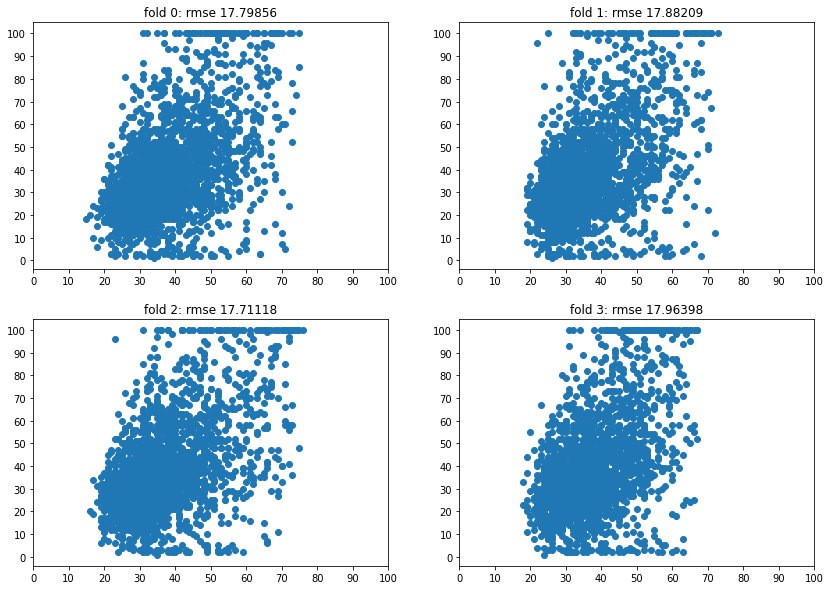

In [27]:
c, r, cnt = 2, 2, 0
fig, axes = plt.subplots(nrows=r, ncols=c, figsize=(14, 10))
for i in range(r):
    for j in range(c):
        if cnt not in all_histories.keys():
            continue
        best_epoch, histories = all_histories[cnt]
        rmse, (pred, gt) = histories[best_epoch][2:]
        axes[i, j].scatter(x=pred, y=gt)
        axes[i, j].set_xticks(np.arange(0,101,10))
        axes[i, j].set_yticks(np.arange(0,101,10))
        axes[i, j].set_title(f"fold {cnt}: rmse {round(rmse,5)}")
        cnt += 1
fig.show()